In [15]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Dict, Any
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

In [2]:
import os
load_dotenv()
groq_api_key  = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment")

In [3]:
llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)

## calculating Batsmen Profile

In [ ]:
class Batsmen(TypedDict):
    runs:int
    fours:int
    six:int
    balls:int
    SR:float
    bpb:float
    b_per:float
    summary:int

In [20]:
def SR(state:Batsmen) ->Dict[str,Any]:
    runs = state['runs']
    balls = state['balls']

    Strike_rate = (runs/balls)*100
    return {"SR":Strike_rate} 


def BPB(state:Batsmen) -> Dict[str,Any]:
    fours = state["fours"]
    six = state['six']
    balls = state["balls"]

    total_boundaries = six+fours

    bpb = balls/total_boundaries
    if bpb <= 0:
        return {"bpb":0}
    return {"bpb":bpb}

def boundary_per(state:Batsmen)->Dict[str,Any]:
    fours = state["fours"]
    six = state["six"]
    runs = state["runs"]

    boundary_runs = (fours*4) + (six*6)
    Boundary_per = (boundary_runs/runs)
    return {"b_per":Boundary_per}

def Summarize(state:Batsmen)->Dict[str,Any]:
    runs = state["runs"]
    fours = state["fours"]
    six = state["six"]
    balls = state["balls"]
    SR = state["SR"]
    bpb = state["bpb"]
    b_per = state["b_per"]

    prompt = f"this is batsmen stats make a detailed profile of it runs = {runs}, fours = {fours} ,six = {six} , balls = {balls} , SR = {SR}, bpb = {bpb} , b_per = {b_per}"
    result = llm.invoke(prompt)
    return {"summary":result}

In [21]:
graph = StateGraph(Batsmen)

graph.add_node("strike_rate",SR)
graph.add_node("balls_per_boundary",BPB)
graph.add_node("balls_per_boundary_percantage",boundary_per)
graph.add_node("Summarize_batsmen_profie",Summarize)

graph.add_edge(START,"strike_rate")
graph.add_edge(START,"balls_per_boundary")
graph.add_edge(START,"balls_per_boundary_percantage")

graph.add_edge("strike_rate","Summarize_batsmen_profie")
graph.add_edge("balls_per_boundary","Summarize_batsmen_profie")
graph.add_edge("balls_per_boundary_percantage","Summarize_batsmen_profie")

graph.add_edge("Summarize_batsmen_profie",END)
workflow = graph.compile()
output = workflow.invoke({"runs":100,"fours":6,"six":4,"balls":50})

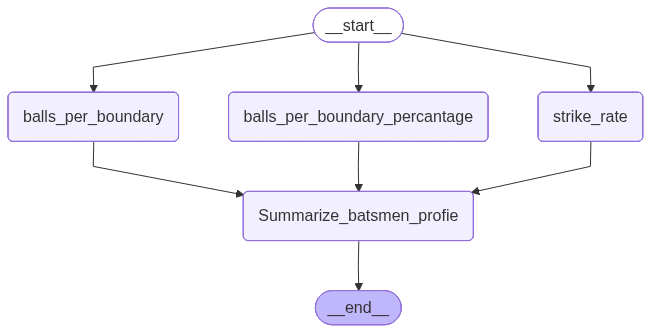

In [11]:
workflow

In [22]:
print(output)

{'runs': 100, 'fours': 6, 'six': 4, 'balls': 50, 'SR': 200.0, 'bpb': 5.0, 'b_per': 0.48, 'summary': AIMessage(content='**Batsman Profile – “The Explosive Finisher”**  \n\n| Metric | Value | Interpretation |\n|--------|-------|----------------|\n| **Runs Scored** | 100 | A century in a single innings – a rare, game‑changing achievement. |\n| **Balls Faced** | 50 | Extremely efficient scoring; the batsman averaged **2 runs per ball**. |\n| **Strike Rate (SR)** | **200.0** | Every 100 balls yields 200 runs – elite‑level aggression (typical T20 SR is 130‑150). |\n| **Fours** | 6 | 24 runs from boundaries. |\n| **Sixes** | 4 | 24 runs from sixes. |\n| **Boundary Count** | 10 (6 fours + 4 sixes) | 10 boundaries in 50 balls → a boundary every **5 balls**. |\n| **Boundary Percentage (b_per)** | **0.48** (48\u202f%) | Almost half of every ball faced ends up as a boundary. |\n| **Runs per Boundary (bpb)** | **5.0** | On average, each boundary contributes 5 runs (mix of fours and sixes). |\n| **R